<a href="https://colab.research.google.com/github/JS0501/ESAA_YB3/blob/main/ESAA_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **[개념 필사]**
##### **앙상블**
##### 여러 개의 분류기(Classifier)를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법
##### 앙상블 학습의 유형은 보팅, 배깅, 부스팅, 스태깅 등
##### 보팅과 배깅을 여러 개의 분류기가 투표를 통해 최종 예측 결과 결정
##### 보팅은 일반적으로 서로 다른 알고리즘을 가진 분류기 결합
##### 배깅은 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅, 대표적으로 랜덤 포레스트
##### 개별 Classifier에게 데이터를 샘플링해서 추출하는 방식: 부트스트래핑(Bootstrapping)
##### 부스팅은 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에게는 가중치(weight)를 부여하면서 학습과 예측 진행
##### **XGBoost**
##### 뛰어난 예측 성능, GBM 대비 빠른 수행 시간, 과적합 규제, Tree pruning(나무 가지치기), 자체 내장된 교차 검증, 결손값 자체 처리

#### **[코드 필사]**

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [2]:
# 개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train,y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test,pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


In [3]:
from google.colab import drive
drive.mount('/content/drivd')

Mounted at /content/drivd


In [7]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                             if x[1]>0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
  return new_feature_name_df

In [9]:
import pandas as pd

def get_human_dataset():

  # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
  feature_name_df = pd.read_csv('/content/drivd/MyDrive/features.txt',sep='\s+', header=None, names=['column_index','column_name'])

  # 중복된 피어명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:,1].values.tolist()

  # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
  X_train = pd.read_csv('/content/drivd/MyDrive/X_train.txt', sep='\s+', names=feature_name)
  X_test = pd.read_csv('/content/drivd/MyDrive/X_test.txt', sep='\s+', names=feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train = pd.read_csv('/content/drivd/MyDrive/y_train.txt', sep='\s+', header=None, names=['action'])
  y_test = pd.read_csv('/content/drivd/MyDrive/y_test.txt', sep='\s+', header=None, names=['action'])

  # 로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

<ipython-input-7-5c1a970a5995>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[1]>0 else x[0], axis=1)
<ipython-input-7-5c1a970a5995>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9220


In [12]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':[8,16,24],
    'min_samples_leaf':[1,6,12],
    'min_samples_split':[2,8,16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 16}
최고 예측 정확도: 0.9157


In [13]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train,y_train)
pred =rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도: 0.9253


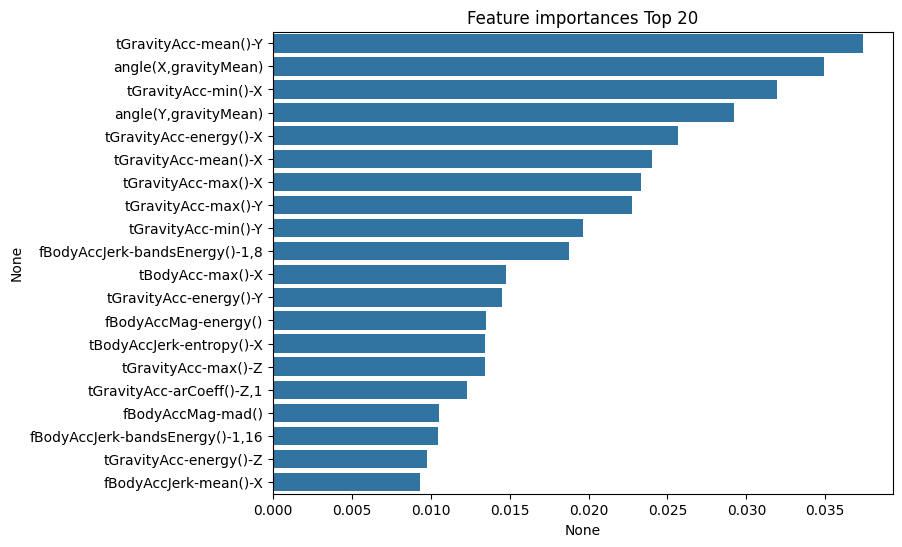

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
# gb_clf.fit(X_train,y_train)
# gb_pred = gb_clf.predict(X_test)
# gb_accuracy = accuracy_score(y_test,gb_pred)

# print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
# print('GBM 수행 시간: {0:.1f}초'.format(time.time()-start_time))
### 계속 기다려도 실행이 안되어 주석 처리 하였습니다.

In [3]:
pip install xgboost

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier

In [6]:
import xgboost
print(xgboost.__version__)

3.0.0


In [9]:
import xgboost as xbg
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target
cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [10]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [11]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 검즘용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [12]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMarix 생성이 안 될 경우 X_train.values로 넘파이 변환
# 학습, 검증, 테스트용 DMatrix를 생성
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [13]:
params = {'max_depth':3,
          'eta':0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'}
num_rounds=400

In [14]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기합니다
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')]만 명기해도 무방

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtr,num_boost_round=num_rounds, early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.62473	eval-logloss:0.63088
[1]	train-logloss:0.58662	eval-logloss:0.60461
[2]	train-logloss:0.55210	eval-logloss:0.58205
[3]	train-logloss:0.52068	eval-logloss:0.56165
[4]	train-logloss:0.49173	eval-logloss:0.54101
[5]	train-logloss:0.46517	eval-logloss:0.52206
[6]	train-logloss:0.44009	eval-logloss:0.50271
[7]	train-logloss:0.41646	eval-logloss:0.48606
[8]	train-logloss:0.39505	eval-logloss:0.46961
[9]	train-logloss:0.37523	eval-logloss:0.45485
[10]	train-logloss:0.35682	eval-logloss:0.44120
[11]	train-logloss:0.33964	eval-logloss:0.43123
[12]	train-logloss:0.32279	eval-logloss:0.41962
[13]	train-logloss:0.30783	eval-logloss:0.40848
[14]	train-logloss:0.29308	eval-logloss:0.39857
[15]	train-logloss:0.27928	eval-logloss:0.38945
[16]	train-logloss:0.26681	eval-logloss:0.38171
[17]	train-logloss:0.25498	eval-logloss:0.37381
[18]	train-logloss:0.24352	eval-logloss:0.36656
[19]	train-logloss:0.23307	eval-logloss:0.36014
[20]	train-logloss:0.22290	eval-logloss:0.35395
[2

In [15]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.776 0.058 0.975 1.    0.999 0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')

    print('정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))

    if pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')  # 다중 클래스용
            print('ROC AUC: {:.4f}'.format(roc_auc))
        except Exception as e:
            print('ROC AUC 계산 중 오류 발생:', e)

get_clf_eval(y_test , preds, pred_probs)

정확도: 0.9649, 정밀도: 0.9600, 재현율: 0.9600, F1: 0.9600
ROC AUC: 0.9965


In [20]:
get_clf_eval(y_test,preds,pred_probs)

정확도: 0.9649, 정밀도: 0.9600, 재현율: 0.9600, F1: 0.9600
ROC AUC: 0.9965


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

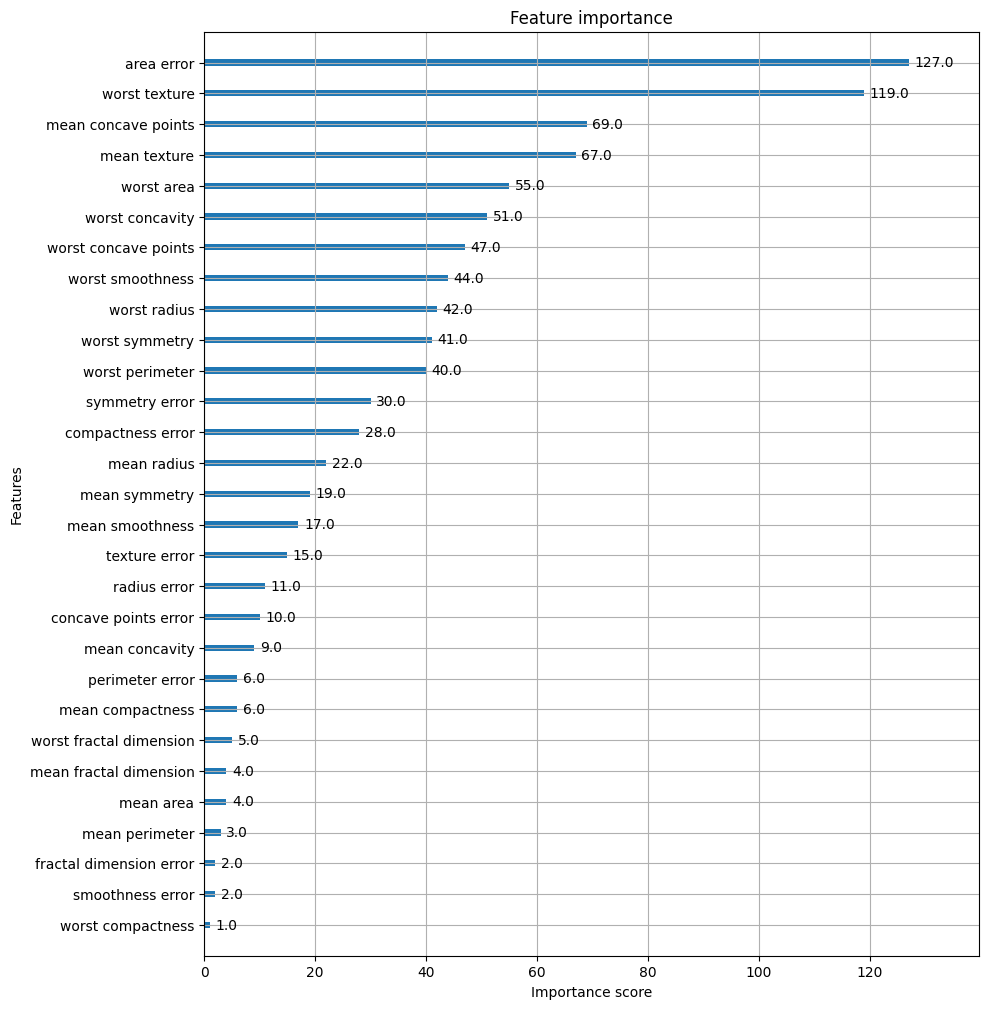

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

In [22]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train,y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [23]:
get_clf_eval(y_test,w_preds,w_pred_proba)

정확도: 0.9649, 정밀도: 0.9667, 재현율: 0.9530, F1: 0.9594
ROC AUC: 0.9951


In [27]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr, early_stopping_rounds=50, eval_metric='logloss',eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [28]:
get_clf_eval(y_test,ws50_preds,ws50_pred_proba)

NameError: name 'ws50_preds' is not defined

In [29]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_preds, ws10_pred_proba)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

NotFittedError: need to call fit or load_model beforehand

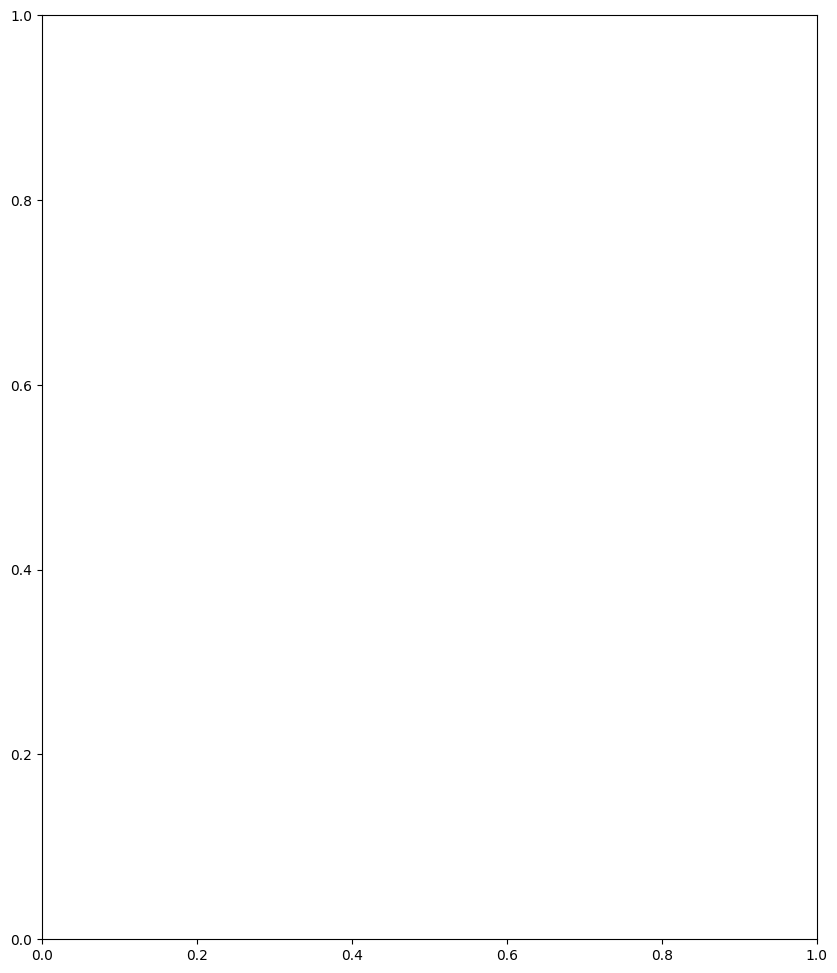

In [30]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper,ax=ax)